In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

sns.set(style="darkgrid")

def load_data(myfile='../data/logins2.json'):
    df = pd.read_json(myfile)
    
    # create a pandas Series with timestamp as index
    ts_series = pd.Series(1,index=df.login_time)
    
    # aggregate the count on 15 minute interval
    data = ts_series.resample('15T').sum()
    data = pd.DataFrame({'login_time':data.index,'login_count':data.values})
    
    return data

data = load_data()
data.head()

,login_count,login_time
0,3,2010-01-01 00:00:00
1,3,2010-01-01 00:15:00
2,7,2010-01-01 00:30:00
3,7,2010-01-01 00:45:00
4,5,2010-01-01 01:00:00


In [22]:
data.dtypes

login_count             int64
login_time     datetime64[ns]
dtype: object

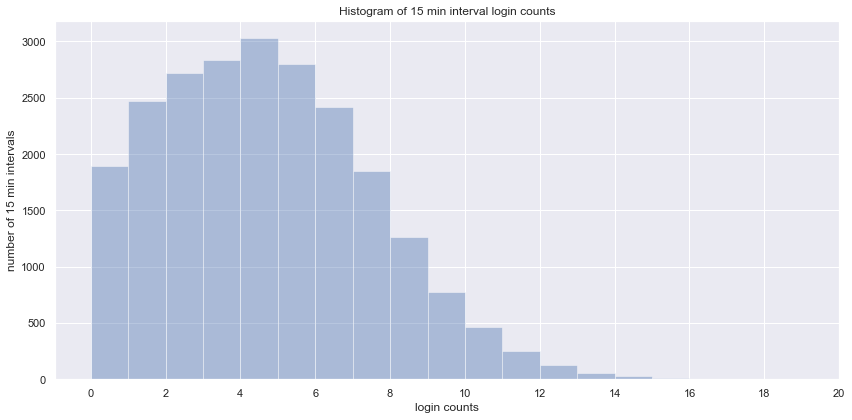

In [23]:
plt.rcParams['figure.figsize'] = [12, 6]
sns.distplot(data.login_count,bins=19,hist_kws={"rwidth":1},kde=False)
plt.title("Histogram of 15 min interval login counts")
plt.xticks(range(0,21,2))
plt.xlabel("login counts")
plt.ylabel("number of 15 min intervals")
plt.tight_layout()
plt.savefig('img/login_count_histogram.png')

In [24]:
print("mean: ",data.login_count.mean())
print("standard deviation: ",data.login_count.std())
print("min login count: ", data.login_count.min())
print("max login count: ", data.login_count.max())

mean:  4.235046078942792
standard deviation:  2.8008738633875034
min login count:  0
max login count:  19


In [25]:
# the function to transform numeric day of week to string values
def create_weekday(x):
    if x == 0:
        return 'Monday'
    elif x == 1:
        return 'Tuesday'
    elif x == 2:
        return 'Wednesday'
    elif x == 3:
        return 'Thursday'
    elif x == 4:
        return 'Friday'
    elif x == 5:
        return 'Saturday'
    elif x == 6:
        return 'Sunday'

# pick week #34 as an example
week34 = data[(data.login_time >= datetime(2010,8,15)) & (data.login_time <= datetime(2010,8,21))]
week34.loc[:,'15 minute interval'] = week34.login_time.apply(lambda x: datetime.strftime(x,'%Y-%m-%d %H:%M:%S')[-8:-3])
week34.loc[:,'week_of_day'] = week34.login_time.apply(lambda x: x.weekday())
week34.loc[:,'weekday'] = week34.week_of_day.apply(lambda x: create_weekday(x))
week34.head()    

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,login_count,login_time,15 minute interval,week_of_day,weekday
21696,7,2010-08-15 00:00:00,00:00,6,Sunday
21697,7,2010-08-15 00:15:00,00:15,6,Sunday
21698,6,2010-08-15 00:30:00,00:30,6,Sunday
21699,6,2010-08-15 00:45:00,00:45,6,Sunday
21700,4,2010-08-15 01:00:00,01:00,6,Sunday


In [26]:
# use pandas pivot table to transform the dataframe

week34_pivot = pd.pivot_table(data=week34,values='login_count',index='15 minute interval',columns='weekday',aggfunc=np.mean)
week34_pivot = week34_pivot.fillna(0)
week34_pivot.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
15 minute interval,,,,,,,
00:00,4.0,3.0,7.0,7.0,3.0,2.0,3.0
00:15,5.0,2.0,0.0,7.0,4.0,2.0,3.0
00:30,3.0,4.0,0.0,6.0,5.0,2.0,2.0
00:45,3.0,0.0,0.0,6.0,3.0,3.0,3.0
01:00,5.0,1.0,0.0,4.0,2.0,2.0,2.0


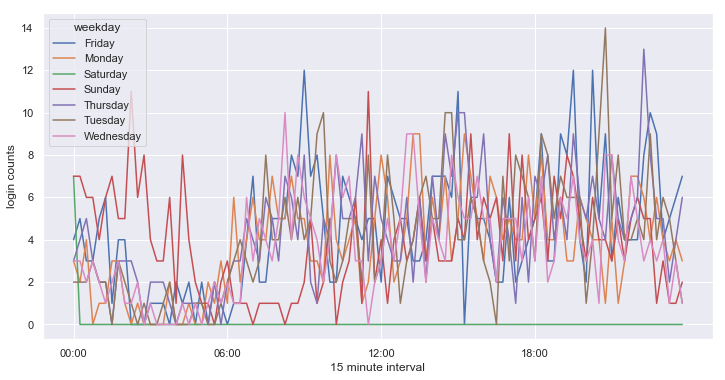

In [27]:
#sns.lineplot(data=week34_pivot, palette="tab10", linewidth=2.5)
week34_pivot.plot()
plt.ylabel("login counts")
plt.xticks([0,24,48,72],['00:00','06:00','12:00','18:00'])
plt.savefig('img/weekday_timeseries_plot.png')

In [28]:
# set the index as login_time

data.index = data.login_time
del data['login_time']

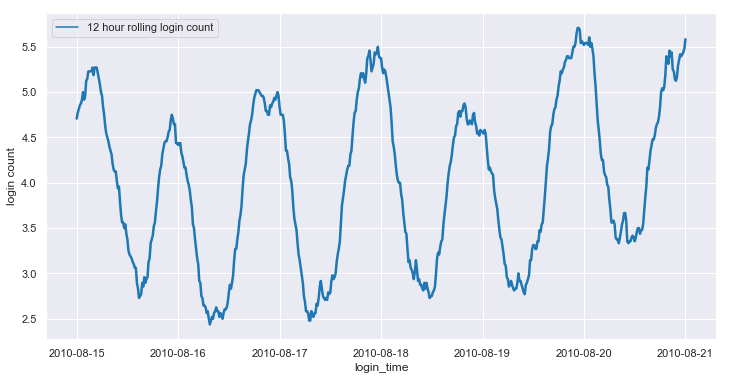

In [31]:
# 12 hour moving average

rolling48 = data.rolling(48).mean()
rolling48.columns = ['12 hour rolling login count']
sns.lineplot(data=rolling48[(rolling48.index >= datetime(2010,8,15)) & \
                            (rolling48.index <= datetime(2010,8,21))]\
             ,palette="tab10", linewidth=2.5)
plt.ylabel('login count')
plt.savefig('img/12_hour_rolling_ts_plot.png')

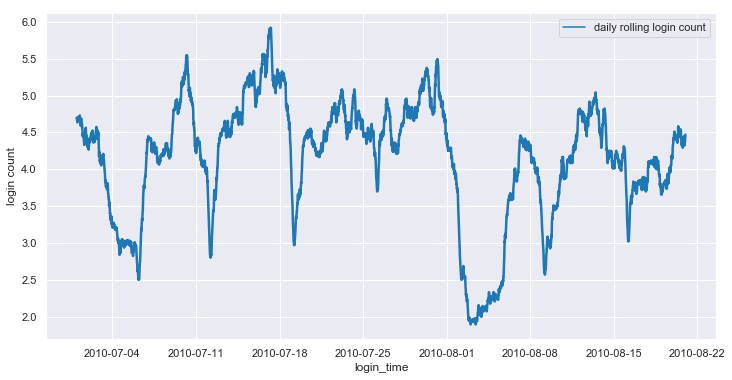

In [36]:
# daily moving (rolling) average from July to August

rolling96 = data.rolling(96).mean()
rolling96.columns = ['daily rolling login count']
sns.lineplot(data=rolling96[(rolling96.index >= datetime(2010,7,1)) & \
                            (rolling96.index <= datetime(2010,8,21))]\
             ,palette="tab10", linewidth=2.5)
plt.ylabel('login count')
plt.savefig('img/daily_rolling_ts_plot_July_Aug.png')

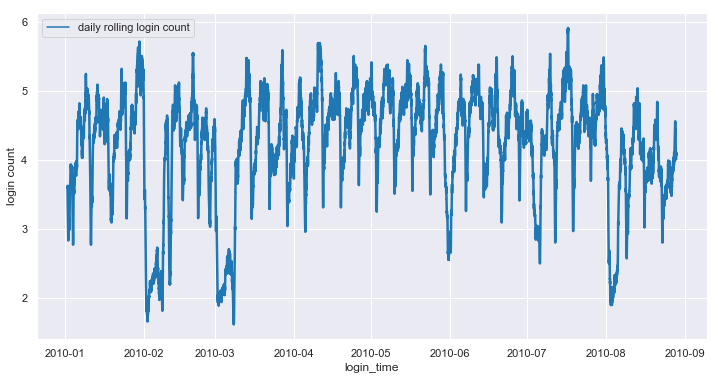

In [37]:
# daily moving (rolling) average during the entire period

rolling96 = data.rolling(96).mean()
rolling96.columns = ['daily rolling login count']
sns.lineplot(data=rolling96,palette="tab10", linewidth=2.5)
plt.ylabel('login count')
plt.savefig('img/daily_rolling_ts_plot.png')

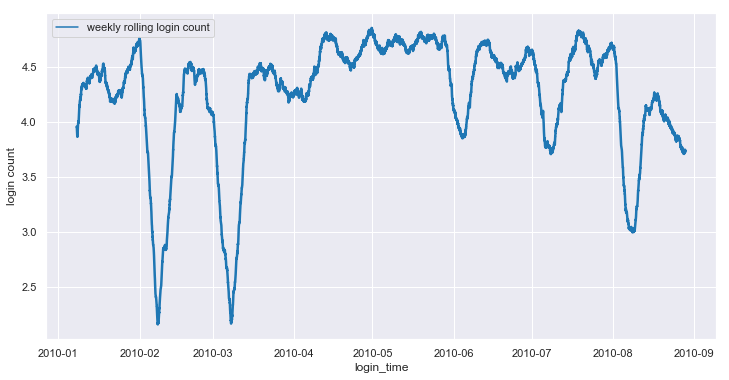

In [19]:
rolling672 = data.rolling(672).mean()
rolling672.columns = ['weekly rolling login count']
sns.lineplot(data=rolling672,palette="tab10", linewidth=2.5)
plt.ylabel('login count')
plt.savefig('img/weekly_rolling_ts_plot.png')

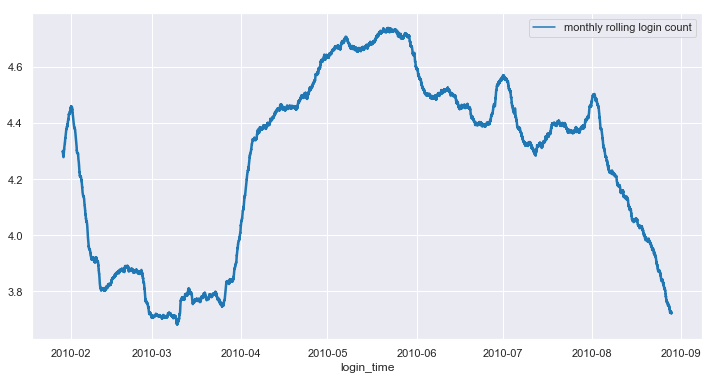

In [20]:
rollingMonthly = data.rolling(672*4).mean()
rollingMonthly.columns = ['monthly rolling login count']
sns.lineplot(data=rollingMonthly,palette="tab10", linewidth=2.5)
plt.savefig('img/monthly_rolling_ts_plot.png')